# Anomaly Detection of FLC Stock Price Using LSTM based Auto Encoders

Kaggle REFERENCE for Base Code

[1] https://www.kaggle.com/code/neeoon/stock-market-manipulation-autoencoders/notebook

Other Similar Codes 

[2] https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9


[3] https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Timeseries%20anomaly%20detection%20using%20LSTM


[4] https://medium.com/@manthapavankumar11/anomaly-detection-in-time-series-data-with-the-help-of-lstm-auto-encoders-5f8affaae7a7

# Section 1 - Introduction 

##  Background on Auto Encoders 

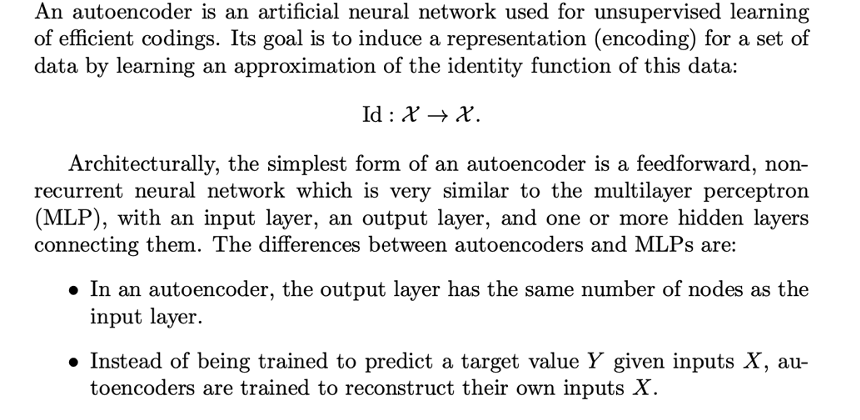

## Architecture of an Autoencoder

(Image Ref: https://philipperemy.github.io/anomaly-detection/![image-2.png](attachment:image-2.png)


 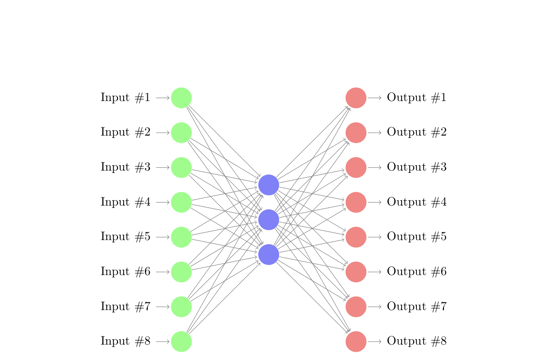

The simplest form of an autoencoder is a feedforward neural network that resembles a multilayer perceptron (MLP). Its architecture consists of:

- Input Layer: Receives the input data.
- Hidden Layers: Encodes and decodes the data.
- Output Layer: Attempts to reconstruct the input.

## How are Auto Encoders used for anomaly detection in Time Series data 

Time series anomaly detection using autoencoders is a method for detecting unusual patterns in sequential data. An autoencoder is a type of neural network that can learn to encode the input data into a lower-dimensional representation and then decode it back to the original input. By training an autoencoder on a dataset of normal time series data, it can learn to reconstruct normal patterns in the data.


The trained autoencoder can be used to reconstruct new data points. If the difference between the original data point and its reconstructed version is above a certain threshold, the data point is considered anomalous. Different types of autoencoders can be used for time series anomaly detection, such as stacked autoencoders, convolutional autoencoders, or recurrent autoencoders and LSTM based ones 


## Application of  Auto Encoder based anomaly detection in Time Series 

Time series anomaly detection using autoencoders has been applied to a variety of domains, such as finance, healthcare, and industry. It can be used for detecting anomalous patterns in financial transactions, detecting unusual behaviour in sensor data, or detecting anomalies in medical time series data. However, it is important to note that autoencoders may not be the best choice for all types of anomaly detection tasks, and other methods such as support vector machines or clustering algorithms may be more appropriate in certain situations.

## Schematic Explanation 

(Image Ref : https://lilianweng.github.io/posts/2018-08-12-vae/![image.png](attachment:image.png))

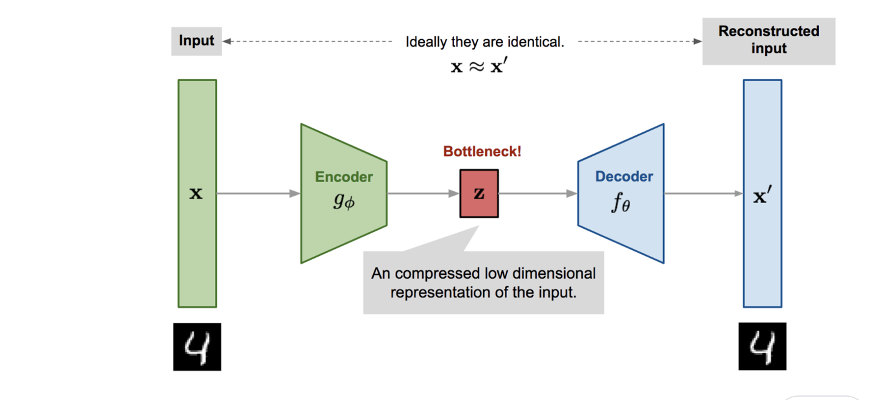

**The idea is quite straightforward:**
    
- Due to the bottleneck architecture of the neural network, it is compelled to learn a compact representation from which it can reconstruct the original input.
- The model is trained exclusively on normal transactions, which it learns to reproduce with high accuracy.
- As a result, if an anomalous transaction is sufficiently different from normal transactions, the autoencoder will struggle to reconstruct it using its learned weights, leading to a high reconstruction loss.
- Any transaction with a reconstruction loss exceeding a specified threshold will be flagged as anomalous.

# Section 2 : Code Demo 

#### Imports

In [7]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

Matplotlib is building the font cache; this may take a moment.


# Data Reads and Basic Data Cleaning

- Check for nulls
- Mean impute for Vol MA column
- Extract Date from Date Time format

In [8]:
# Read dataset 
df = pd.read_csv("flc_unlabeled_time_series.csv")


# check Non Null count and Data type
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       2170 non-null   object 
 1   open       2170 non-null   float64
 2   high       2170 non-null   float64
 3   low        2170 non-null   float64
 4   close      2170 non-null   float64
 5   Volume     2170 non-null   int64  
 6   Volume MA  2151 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 118.8+ KB


In [9]:
# Mean impute for the column Volume MA
df['Volume MA'] = df['Volume MA'].fillna(df['Volume MA'].mean())

# extract Only the Date portion from a timestamp format
time = df['time'].str.split("T", expand = True)
df['time'] = time[0]

# check
df.head()

,time,open,high,low,close,Volume,Volume MA
0,2013-08-06,4104.330818,4176.336622,4032.325014,4104.330818,6158668,1.367749e+07
1,2013-08-07,4104.330818,4104.330818,3960.319210,4032.325014,4937960,1.367749e+07
2,2013-08-08,4032.325014,4104.330818,3960.319210,3960.319210,2287341,1.367749e+07
3,2013-08-09,3960.319210,4032.325014,3888.313406,3960.319210,2425496,1.367749e+07
4,2013-08-12,3960.319210,3960.319210,3816.307603,3816.307603,3534864,1.367749e+07


# Get time range
- Print the Start and the End of the Date Range

In [10]:
# Print Start Value of Date Range
print("Start", df['time'].min())

# Print Start Value of Date Range
print("End",  df['time'].max())

Start 2013-08-06
End 2022-05-04


# Extract necessary columns from dataframe

- We exttract only the `time` and `close` columns

In [11]:
df = df[['time', 'close']]
print(df['time'].min(), df['time'].max())
df.head()
df.info()

2013-08-06 2022-05-04
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    2170 non-null   object 
 1   close   2170 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.0+ KB


# Plotting data
- Plot the closing price Vs Date

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['close'], name='Close price'))
fig.update_layout(showlegend=True, title='FLC. Stock Price 2013-2022')
fig.show()

* It's obvious that after 2021, there's a spike in close price of FLC Stock
* We'll assume there're no anomaly before the 2021 point.

### Prepare Train and Test Data

- Train - All data upto and including  2021-01-01
- Test - All data beyond 2021-01-01

In [13]:
train = df.loc[df['time'] <= '2021-01-01']
test = df.loc[df['time'] > '2021-01-01']
train.shape, test.shape

((1841, 2), (329, 2))

# Scaling data

- A standard scaler is fit onto the training data
- The fitted scaler is then used to scale the train and test data

In [14]:
# Initiate Standard Scaler
scaler = StandardScaler()

# Fit scaler on Train Data
scaler = scaler.fit(train[['close']])

# Scale using fitted model on train data
train['close'] = scaler.transform(train[['close']])

# Scale using fitted model on test data
test['close'] = scaler.transform(test[['close']])

/var/folders/1m/07kgjdg97477jnhwzd0w8gyh0000gn/T/ipykernel_57141/35504918.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1m/07kgjdg97477jnhwzd0w8gyh0000gn/T/ipykernel_57141/35504918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot Scaled Data

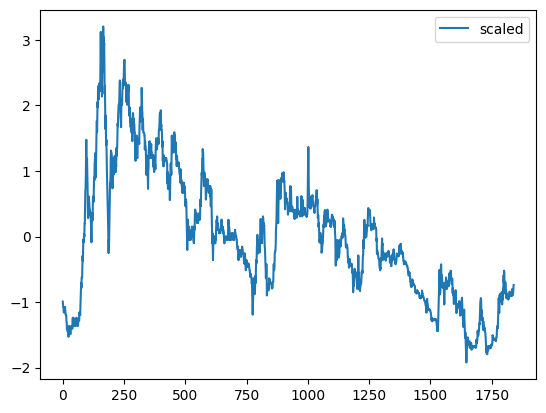

In [15]:
import matplotlib.pyplot as plt


plt.plot(train['close'], label = 'scaled')
plt.legend()
plt.show()


### Prepare X and y data

**Notes**

- We have 1841 sequential values of closing stock prices as per Train data set
- A rolling block of 30 sequential values is selected as X data : The next value is treated as the corresponding 'y' data

In [16]:
# Set Time Steps
TIME_STEPS=30

# define function to create X , Y data
def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

# Create X Train and y Train
X_train, y_train = create_sequences(train[['close']], train['close'])

# Create X  Test and y Test
X_test, y_test = create_sequences(test[['close']], test['close'])

# Check shape
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1811, 30, 1)
Testing input shape:  (299, 30, 1)


# Set random seed

In [17]:
np.random.seed(21)
tf.random.set_seed(21)

# Building model

### Define Auto Encoders with LSTM


#### Model Definition

`model = Sequential()`

- Initializes a sequential model, which allows stacking layers one after another.


#### Encoder Definition

`model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))`


- Adds an LSTM layer with:
  - 128 units: Number of neurons in the layer.
  - Activation = 'tanh': Hyperbolic tangent activation function, standard for LSTM layers.
  - Input shape = (X_train.shape[1], X_train.shape[2]):
    - X_train.shape[1]: Number of time steps (sequence length).
    - X_train.shape[2]: Number of features for each time step.
- This layer processes sequential data, encodes it, and reduces the dimensionality (latent space representation).

#### Drop Out Layer

`model.add(Dropout(rate=0.2))`

- Adds a dropout layer with a dropout rate of 20%. This helps prevent overfitting by randomly setting 20% of the weights to zero during training.


#### Bottleneck

`RepeatVector(n=X_train.shape[1])`

- Duplicates the latent vector (output from the encoder) across all time steps.
- This prepares the compressed representation for the decoder, effectively matching the time steps of the input sequence.


#### Decoder

`LSTM(units=128, return_sequences=True)'

- Adds another LSTM layer with 128 units.
- `return_sequences=True:` Ensures the LSTM outputs a sequence for each time step, required for reconstructing the input sequence.


'Dropout(rate=0.2)'
- Adds another dropout layer to prevent overfitting in the decoder.

#### Output- Time Distributed Layer

`TimeDistributed: `

- Ensures the Dense layer is applied to each time step independently.

`Dense(units=X_train.shape[2]):`

- Outputs the same number of features as the input for each time step.
- Reconstructs the input data.

#### Compile the Model

`model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")`

`Optimizer = Adam:`

- Adaptive optimization algorithm.

`Learning rate = 0.001`
-  (default for Adam).

`Loss = 'mse':`

- Mean squared error (MSE) is used to measure reconstruction error (difference between input and reconstructed sequence).

#### Summary

`model.summary()`

Prints a summary of the model, including the number of layers, shapes of inputs/outputs, and the total number of trainable parameters.


In [18]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

/Users/anishroychowdhury/anaconda3/envs/LLM/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

`history = model.fit()`

- Purpose: Trains the model on the input data `(X_train, y_train)` for a specified number of epochs, while tracking performance metrics.

`epochs=100`

- Specifies the maximum number of passes through the entire training dataset.
- Higher epochs can improve learning but may lead to overfitting if unchecked.

`batch_size=32`

- Batch size is the number of samples the model processes before updating weights.

- Smaller batch sizes provide more updates per epoch (finer adjustments to the model's weights), but they increase training time.

`validation_split=0.1`

- Reserves 10% of the training data (X_train and y_train) as a validation set.
- The model evaluates its performance on this subset after each epoch to monitor generalization and tune hyperparameters.

`callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]`

**EarlyStopping** halts training early if the monitored metric (here, val_loss) stops improving.

- `monitor='val_loss'`: Watches the validation loss during training.
- `patience=5:` Training stops if validation loss doesn't improve for 5 consecutive epochs.
- `mode='min':` Looks for a minimum in the validation loss (smaller loss is better).

`shuffle=False`

- Prevents shuffling of training data before each epoch.
- **Reason to avoid shuffling:**

  - In time-series data, the temporal order is crucial and should remain intact during training.
  - Shuffling would destroy this sequential dependency.

  `history = ...`

- The history object stores the model's performance metrics (loss, validation loss, etc.) for each epoch.
- You can use history.history to extract these metrics for visualization or further analysis.


In [19]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.5177 - val_loss: 0.0932
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3873 - val_loss: 0.1004
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4144 - val_loss: 0.1045
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3562 - val_loss: 0.0673
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.3041 - val_loss: 0.0620
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3053 - val_loss: 0.0604
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.3161 - val_loss: 0.0583
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.3231 - val_loss: 0.0576
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.3202 - val_loss: 0.0557
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.3170 - val_loss: 0.0562
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.3097 - val_loss: 0.0529
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step

### Loss Analysis

- Plot training and validation loss
- Histogram plot of MAE Loss on train data
- Set threshold of loss to  max value of train loss
- Histogram plot of MAE Loss on test data



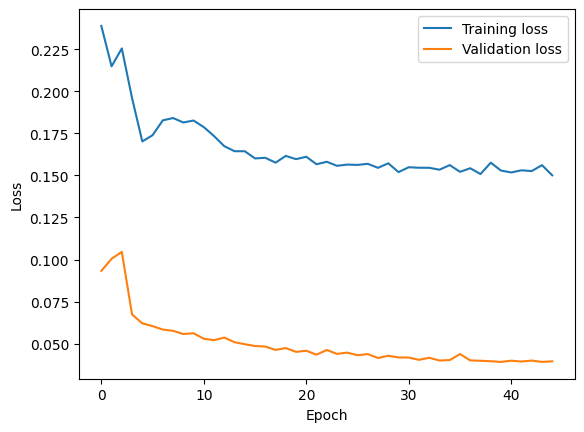

In [20]:
# Plotting training & validation loss

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Reconstruction error threshold: 1.611732148761672


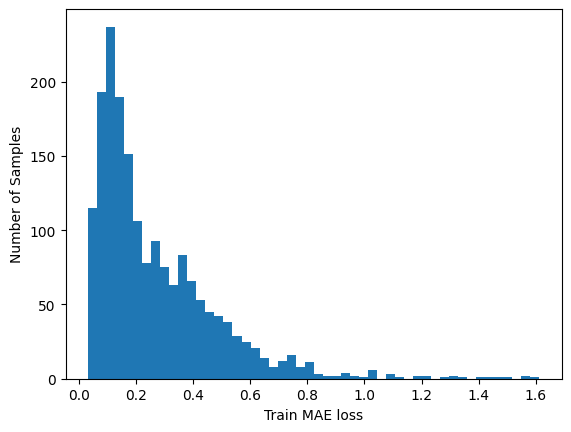

In [21]:
# Plotting MAE loss on train data

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Text(0, 0.5, 'Number of samples')

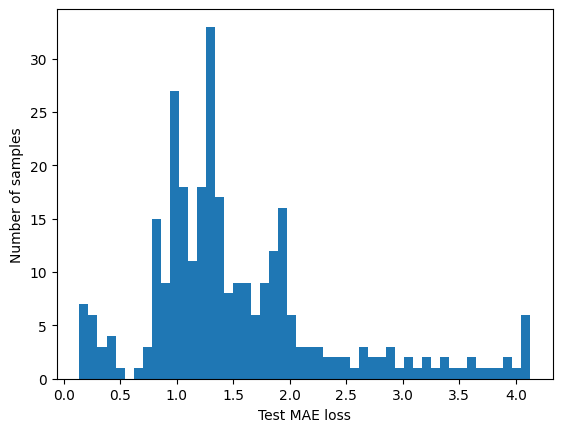

In [22]:
# Plotting MAE loss on test data

X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

### Data preparation for plotting  anomalies

- Subset the test data top include data points post the initial count of TIMESTEPS
- set threshold to be a constant value
- create a Boolean feature : 'anomaly' if loss exceeds threshold


In [23]:
# feature engineering for plotting anomalies

anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']
anomaly_df['close'] = test[TIME_STEPS:]['close']

# check
anomaly_df.head()


,time,close,loss,threshold,anomaly
1871,2021-02-22,0.272766,0.413385,1.611732,False
1872,2021-02-23,0.175629,0.396643,1.611732,False
1873,2021-02-24,0.118490,0.357662,1.611732,False
1874,2021-02-25,0.147060,0.326786,1.611732,False
1875,2021-02-26,0.255624,0.297873,1.611732,False


In [25]:
# Specify file path
file_path = "anomaly.csv"



# Save DataFrame to local drive as a CSV file
anomaly_df.to_csv(file_path, index=False)

# display saved path
print(f"DataFrame saved to {file_path}")



DataFrame saved to anomaly.csv


# RESTART CODE FROM HERE IF Training has been completed and feature engineered Anomaly DF has been created

### Read back the feature engineered Anomaly dataframe from drive storage

In [27]:
# Read the DataFrame back
file_path = "anomaly.csv"
df_loaded = pd.read_csv(file_path)
print("DataFrame loaded from file:")

df_loaded.head()

DataFrame loaded from file:


,time,close,loss,threshold,anomaly
0,2021-02-22,0.272766,0.413385,1.611732,False
1,2021-02-23,0.175629,0.396643,1.611732,False
2,2021-02-24,0.118490,0.357662,1.611732,False
3,2021-02-25,0.147060,0.326786,1.611732,False
4,2021-02-26,0.255624,0.297873,1.611732,False


### Plot Test Loss  with anomaly threshold  

In [28]:
# Initiate Figure
fig = go.Figure()

# Plot Loss in recontsruction vs date  for test data
fig.add_trace(go.Scatter(x=df_loaded['time'], y=df_loaded['loss'], name='Test loss'))

# plot a horizontal line across all the test data at threshold level
fig.add_trace(go.Scatter(x=df_loaded['time'], y=df_loaded['threshold'], name='Threshold'))

# Set Title and legend
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')

# Display figure
fig.show()

### Subset the anomalous data rows based on Boolean feature

In [29]:
# subset
anomalies = df_loaded.loc[df_loaded['anomaly'] == True]

# check
anomalies.head()

,time,close,loss,threshold,anomaly
88,2021-06-29,4.461061,1.632374,1.611732,True
89,2021-06-30,4.261074,1.667337,1.611732,True
90,2021-07-01,4.318213,1.713220,1.611732,True
91,2021-07-02,4.118226,1.741794,1.611732,True
92,2021-07-05,3.689683,1.784559,1.611732,True


###  Mark Anomaly points on Actual data

In [30]:
import plotly.graph_objects as go
import numpy as np

# Initiate figure
fig = go.Figure()

# Inverse transform closing prices and plot vs timeline
close_prices_scaled = df_loaded['close'].values.reshape(-1, 1)  # Reshape to 2D array
close_prices_original = scaler.inverse_transform(close_prices_scaled).flatten()  # Transform back and flatten
fig.add_trace(go.Scatter(
    x=df_loaded['time'],
    y=close_prices_original,
    name='Close price',
    line=dict(color='blue')
))

# Inverse transform anomaly prices and plot
anomaly_prices_scaled = anomalies['close'].values.reshape(-1, 1)  # Reshape to 2D array
anomaly_prices_original = scaler.inverse_transform(anomaly_prices_scaled).flatten()  # Transform back and flatten
fig.add_trace(go.Scatter(
    x=anomalies['time'],
    y=anomaly_prices_original,
    mode='markers',
    name='Anomaly',
    marker=dict(
        color='red',
        size=10,
        symbol='circle'
    )
))

# Define layout
fig.update_layout(
    title='Stock Price Anomalies Detection',
    title_x=0.5,  # Center the title
    xaxis_title='Time',
    yaxis_title='Price',
    showlegend=True,
    template='plotly_white',  # Clean white background
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Show the plot
fig.show()